**USE CASE:**
    
There will be thousands of reviews, you would like to know how much is a review relavant to the product feature.

Suppose you get a review : "The phone camera is awesome"
    
Your product features/specs mentioned has (camera, NETWORK, MEMORY,SOUND, Battery etc).
By finding the similarity between the review and product feature you can know the most reviewed feature and how positive and nagative(sentiment analysis, in other project)

In [1]:
import requests
from bs4 import BeautifulSoup

import spacy
nlp=spacy.load("en_core_web_sm")

import warnings
warnings.filterwarnings("ignore")

import re
from numpy.linalg import norm
from numpy import dot

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Extracting the products

In [2]:
tr_link1="https://www.trustradius.com/crm?f=0&s=237"
link1=requests.get(tr_link1).text

tr_link2="https://www.trustradius.com/crm?f=100&s=237"
link2=requests.get(tr_link2).text

tr_link3="https://www.trustradius.com/crm?f=200&s=100"
link3=requests.get(tr_link3).text

links=[link1,link2,link3]

product_list=[]

for i in links:
    soup=BeautifulSoup(i,"lxml")
    for tag in soup.find_all(True, {'class':['product-link']}):
    
        if tag.name=="a" and tag.string!=None: 
            product_list.append(tag.string)

In [3]:
len(list(set(product_list)))

0

## Product "Insightly" Features

In [4]:
feature_url="https://www.trustradius.com/products/insightly/reviews#1"
soup=BeautifulSoup(requests.get(feature_url).text,"lxml")

In [5]:
features=[]
for tag in soup.find_all(True, {'class':['feature-group-name','supported-feature']}):
    if tag.name=="b" :        
        k=tag.text
    if tag.name=="h5" :        
        k=tag.text
    if tag.name=="div":
        features.append((k+tag.text[11:]).replace("Features","").replace("management",""))

In [6]:
features

['Sales Force Automation Customer data  / contact ',
 'Sales Force Automation Workflow ',
 'Sales Force Automation Territory ',
 'Sales Force Automation Opportunity ',
 'Sales Force Automation Integration with email client (e.g., Outlook or Gmail)',
 'Sales Force Automation Quote & order ',
 'Sales Force Automation Interaction tracking',
 'Marketing Automation Lead ',
 'Marketing Automation Email marketing',
 'CRM Project Management Task ',
 'CRM Project Management Reporting',
 'CRM Reporting & Analytics Pipeline visualization',
 'CRM Reporting & Analytics Customizable reports',
 'Customization Custom fields',
 'Customization Custom objects',
 'Customization API for custom integration',
 'Security Role-based user permissions',
 'Security Single sign-on capability',
 'Integrations with 3rd-party Software Marketing automation',
 'Platform Mobile access',
 'Additional AICPA SOC II Type 1 and Type 2 audited and accredited, and US/EU Privacy Shield and US/Swiss Privacy Shield certified.',
 

## Reviews Extraction

In [7]:
reviews_url="https://www.trustradius.com/products/insightly/reviews?f="
reviews_url1=requests.get(reviews_url).text

In [8]:
list_of_links=[]
for i in range(0,350,25):
    
    final_link=(reviews_url+str(i))
    final_link=requests.get(final_link).text
    list_of_links.append(final_link)   

In [9]:
reviews=[]
for i in list_of_links:
    soup=BeautifulSoup(i,"lxml")
    for tag in soup.find_all(True,{'class':['review-questions']}):

        if tag.name=="div":   
            reviews.append(tag.text[30:].replace("Likelihood to Recommend"," ").replace("Pros and Cons"," "))            
len(reviews)

317

In [10]:
reviews[1]

'We\'re using Insightly primarily for our sales team as a CRM system, tracking organisations, contacts, opportunities and in the future, projects.This information is coupled with our budgets to provide the proverbial "BIGGER PICTURE" Organizational, contact and opportunity management. We\'re able to store relevant data about all three specific information areas. In particular, the progression of opportunities through custom phases is a big plus for us.Great reports that are customizable to my department\'s needs.The easy user interface made the transition from our previous product relatively pain free for our users. Not to say what we used, but you had to be a wise old \'sage\' to use it...EditIntegration to Xero should allow us to quote directly from Insightly, or be able to view our Xero quotes in Insightly.It would also be great to be able to track quotes against a budget or target! Well suited to client management.Not too well suited to quoting!Read Jeremy Grant\'s full review'

## Removing Stopwords and tokenisation

In [11]:
final_feature_list=[]
final_feature=[]
for i in features:
    token_words=[]
    i=re.sub("\W+"," ",i)
    for j in i.split(" "):
        if j not in stop_words and len(j)>2:
            token_words.append(j)
    final_feature_list.append(token_words)
    final_feature.append(" ".join(token_words))

In [12]:
final_feature

['Sales Force Automation Customer data contact',
 'Sales Force Automation Workflow',
 'Sales Force Automation Territory',
 'Sales Force Automation Opportunity',
 'Sales Force Automation Integration email client Outlook Gmail',
 'Sales Force Automation Quote order',
 'Sales Force Automation Interaction tracking',
 'Marketing Automation Lead',
 'Marketing Automation Email marketing',
 'CRM Project Management Task',
 'CRM Project Management Reporting',
 'CRM Reporting Analytics Pipeline visualization',
 'CRM Reporting Analytics Customizable reports',
 'Customization Custom fields',
 'Customization Custom objects',
 'Customization API custom integration',
 'Security Role based user permissions',
 'Security Single sign capability',
 'Integrations 3rd party Software Marketing automation',
 'Platform Mobile access',
 'Additional AICPA SOC Type Type audited accredited Privacy Shield Swiss Privacy Shield certified',
 'Additional Data import export',
 'Additional Two factor Authentication 2FA',


In [13]:
final_review_list=[]
final_review=[]

for i in reviews:
    token_words=[]
    i=re.sub("\W+"," ",i)
    for j in i.split(" "):
        if j not in stop_words and len(j)>2 and j.lower()!="insightly":
            token_words.append(j)
    final_review_list.append(token_words)
    final_review.append(" ".join(token_words))

## Plotting Most Frequent words

In [14]:
def freq_words(x, terms = 30):
    words=" "
    for j in x:
        for i in j:
            words=words+i+" "
    
    words = words.split()

    fdist = FreqDist(words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

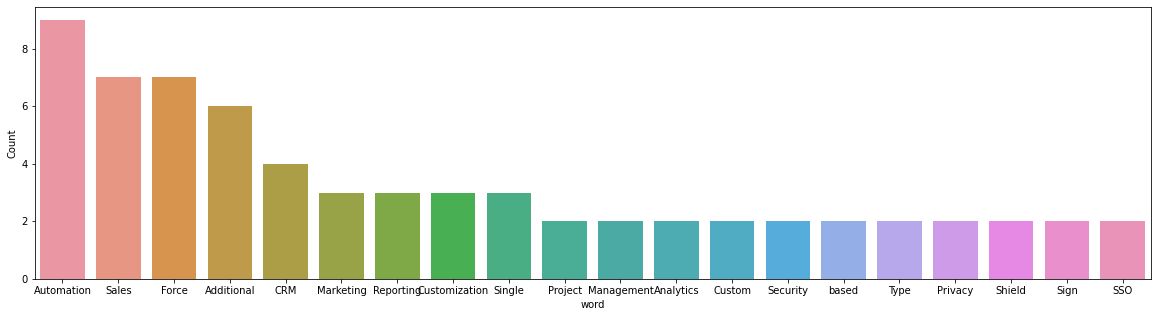

In [15]:
freq_words(final_feature_list,terms=20)

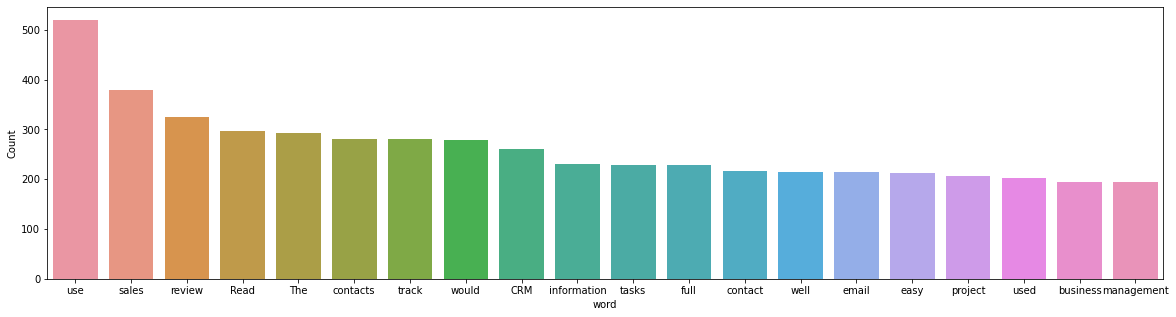

In [16]:
freq_words(final_review_list,terms=20)

## Finding the correlation between a review and a particular Feature of the product

There are differet methods to get the sentence vectors :\

**Doc2Vec** : you can train your dataset using Doc2Vec and then use the sentence vectors.

**Average of Word2Vec vectors**: You can just take the average of all the word vectors in a sentence. This average vector will represent your sentence vector.(Using this)

**Average of Word2Vec vectors with TF-IDF** : this is one of the best approach which I will recommend. Just take the word vectors and multiply it with their TF-IDF scores. Just take the average and it will represent your sentence vector.

In [17]:
##https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469

EMBEDDING_FILE="C:/Users/ramya/Downloads/glove.6B/glove.6B.100d.txt"

# this embedding file can be downloaded online https://nlp.stanford.edu/projects/glove/

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE,encoding='utf-8'))

In [18]:
def vec(s):
    return embeddings_index[s.lower()]

In [19]:

def meanv_sent(coords):
    # assumes every item in coords has same length as item 0
    a=0
    running_sum=0
    for w in coords.split():
        if w.lower() in embeddings_index.keys():
            a=a+1
            running_sum=running_sum+vec(w.lower())
        
    return (running_sum/max(a,1))

In [20]:
meanv_sent("goose geese")

array([-4.0561500e-01,  3.3013499e-01,  4.2058501e-01, -3.7959993e-02,
       -2.4814050e-01, -6.9466501e-02, -3.4714502e-01,  2.2136500e-01,
       -3.0033001e-01, -9.9291503e-01, -1.1006950e+00,  6.5036500e-01,
        5.8976001e-01,  4.6939999e-01,  1.8093389e-01,  7.0989996e-02,
       -2.5589001e-01,  2.3566499e-01,  2.3278500e-01,  4.2712000e-01,
        1.3359851e-01,  7.8539002e-01,  3.7312502e-01, -3.4635001e-01,
        5.9943497e-01,  7.8926498e-01, -6.0883498e-01,  5.5585998e-01,
       -2.3996499e-01,  3.4034997e-01,  1.2107998e-01,  3.5529500e-01,
        5.4617500e-01,  4.3185502e-01,  8.5548997e-02, -1.2937000e-01,
       -1.6336000e-01,  3.8295001e-01,  2.7146500e-01, -6.9993496e-01,
        1.2568000e-01, -1.7098500e-01, -7.1828496e-01, -3.9222500e-01,
        2.3403251e-01,  8.7463498e-01, -8.3482996e-02, -9.8019993e-01,
       -7.6495498e-02, -6.6744998e-02, -1.2110500e-01, -5.3388500e-01,
       -3.4731501e-01,  3.8390499e-01, -8.1520998e-01, -2.6416999e-01,
      

In [21]:
# cosine similarity

def cosine(v1, v2):
    if norm(v1) > 0 and norm(v2) > 0:
        return dot(v1, v2) / (norm(v1) * norm(v2))
    else:
        return 0.0

In [22]:
v="initially started whole organization scaled back use sales department works great putting information new leads one central location tracking use follow process initial contact sales beyond helps know currently importantly next fairly intuitive seems function well helps keep track new contacts Share information multiple users contacts updated able open see potential customer sales process Assigning tasks simple check EditWe issues contacts trouble integrating Google contacts sure bigger problem use plan limited data issues running space learned use better problem disappeared hit big problem The activity sets option nice feature found difficult learn The rest fairly straightforward took time functioned differently worth taking time learn guess process could simplified really liked tracking sales process well great place keep information new leads weed determine likely become sale really like activity sets well These allow set repeated activity use bit tweaking stated trouble figuring initially worth effort would stay away contacts want sync Google contacts two worked well Read Bil Thompson full review"

In [23]:
cosine((meanv_sent('Sales Force Automation Territory')), (meanv_sent(v)))

0.7360215

### Building the Matrix

In [24]:
df = pd.DataFrame(columns = final_feature)

In [25]:
for i in range(len(final_review)):
    df = df.append({'Security Single sign capability': i}, ignore_index=True)

In [26]:
df.index=final_review

In [28]:
df.columns[0]

'Sales Force Automation Customer data contact'

In [29]:
df.index[0]

'initially started whole organization scaled back use sales department works great putting information new leads one central location tracking use follow process initial contact sales beyond helps know currently importantly next fairly intuitive seems function well helps keep track new contacts Share information multiple users contacts updated able open see potential customer sales process Assigning tasks simple check EditWe issues contacts trouble integrating Google contacts sure bigger problem use plan limited data issues running space learned use better problem disappeared hit big problem The activity sets option nice feature found difficult learn The rest fairly straightforward took time functioned differently worth taking time learn guess process could simplified really liked tracking sales process well great place keep information new leads weed determine likely become sale really like activity sets well These allow set repeated activity use bit tweaking stated trouble figuring i

In [31]:
for i in range(0,len(df.columns)):
    for j in range(0,len(df)):
        df.iloc[j][i]=cosine(meanv_sent(df.index[j]), meanv_sent(df.columns[i])) 

In [32]:
df.head(10)

,Sales Force Automation Customer data contact,Sales Force Automation Workflow,Sales Force Automation Territory,Sales Force Automation Opportunity,Sales Force Automation Integration email client Outlook Gmail,Sales Force Automation Quote order,Sales Force Automation Interaction tracking,Marketing Automation Lead,Marketing Automation Email marketing,CRM Project Management Task,...,Security Role based user permissions,Security Single sign capability,Integrations 3rd party Software Marketing automation,Platform Mobile access,Additional AICPA SOC Type Type audited accredited Privacy Shield Swiss Privacy Shield certified,Additional Data import export,Additional Two factor Authentication 2FA,Additional SAML based Single Sign SSO,Additional OAuth Single Sign SSO,Additional Audit Logs
initially started whole organization scaled back use sales department works great putting information new leads one central location tracking use follow process initial contact sales beyond helps know currently importantly next fairly intuitive seems function well helps keep track new contacts Share information multiple users contacts updated able open see potential customer sales process Assigning tasks simple check EditWe issues contacts trouble integrating Google contacts sure bigger problem use plan limited data issues running space learned use better problem disappeared hit big problem The activity sets option nice feature found difficult learn The rest fairly straightforward took time functioned differently worth taking time learn guess process could simplified really liked tracking sales process well great place keep information new leads weed determine likely become sale really like activity sets well These allow set repeated activity use bit tweaking stated trouble figuring initially worth effort would stay away contacts want sync Google contacts two worked well Read Bil Thompson full review,0.802219,0.607808,0.736022,0.799392,0.707514,0.806870,0.750199,0.676338,0.556912,0.661721,...,0.821237,0.840217,0.659010,0.665413,0.651022,0.704456,0.800172,0.742397,0.654031,0.609618
using primarily sales team CRM system tracking organisations contacts opportunities future projects This information coupled budgets provide proverbial BIGGER PICTURE Organizational contact opportunity management able store relevant data three specific information areas particular progression opportunities custom phases big plus Great reports customizable department needs The easy user interface made transition previous product relatively pain free users Not say used wise old sage use EditIntegration Xero allow quote directly able view Xero quotes would also great able track quotes budget target Well suited client management Not well suited quoting Read Jeremy Grant full review,0.826542,0.647071,0.736574,0.810256,0.752699,0.824230,0.771297,0.698863,0.611353,0.699571,...,0.866792,0.849949,0.704812,0.714322,0.700232,0.749015,0.821416,0.776864,0.680909,0.653635
used whole sales department people Customer Success process manage Inbound Leads another process Outbound prospecting based Cold Emails The problem good tools prospecting cold emails every salesman create tasks follow ups That main reason changed CRM For Customer Success used Project tab allowed Project Manager Account Manager communicate process implementation salesman Link Sales Project ManagersStages opportunitiesEditManaging LeadsWorkflows task assignment well suited low budget small sales team work tasks manually much better working spreadsheet history leads lot integrations scale grow Read Ignacio Cruz full review,0.837457,0.684624,0.764918,0.833559,0.760574,0.825018,0.789942,0.744004,0.648484,0.754444,...,0.837091,0.832662,0.728918,0.674854,0.641189,0.731394,0.786942,0.744839,0.649087,0.648338
entertainment field always looking leads quarterly magazine really need way follow contacts keep information order Our social media team used needs little year starting free trial version switching Pro Simple point click lead cr